## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Anna Tarelina (@feuerengel). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment #3. Optional part
## <center> Implementation of the decision tree algorithm

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

Let's fix `random_state` (a.k.a. random seed) beforehand.

In [2]:
RANDOM_STATE = 17

**Implement the class `DecisionTree`**
**Specification:**
- the class is inherited from `sklearn.BaseEstimator`;
- class constructor has the following parameters: 
    `max_depth` - maximum depth of the tree (`numpy.inf` by default); 
    `min_samples_split` - the minimum number of instances in a node for a splitting to be done (2 by default); 
    `criterion` - split criterion ('gini' or 'entropy' for classification, 'variance' or 'mad_median' for regression; 'gini' by default);
    
    A functional to be maximized to find an optimal partition at a given node has the form
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    where $X$ are samples at a given node, $X_l$ and $X_r$ are partitions of samples $X$ into two parts 
    with the following condition $[x_j < t]$, and $F(X)$ is a partition criterion.
    
    For classification: let $p_i$ be the fraction of the instances of the $i$-th class in the dataset $X$.
    
    'gini': Gini impurity $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Entropy $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    For regression: $y_j = y(x_j)$ - is a target for an instance $x_j$, $y = (y_1, \dots, y_{|X|})$ - is a target vector.
    
    'variance': Variance (mean quadratic deviation from average) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Mean deviation from the median $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- the class has several methods: `fit`, `predict` and `predict_proba`;
- the`fit` method takes the matrix of instances `X` and a target vector `y` (`numpy.ndarray` objects) and returns an instance of the class `DecisionTree` representing the decision tree trained on the dataset `(X, y)` according to parameters set in the constructor; 
- the `predict_proba` method takes the matrix of instances `X` and returns the matrix `P` of a size `X.shape[0] x K`, where `K` is the number of classes and $p_{ij}$ is the probability of an instance in $i$-th row of `X` to belong to class $j \in \{1, \dots, K\}$.
- the `predict` method takes the matrix of instances `X` and returns a prediction vector; in case of classification, prediction for an instance $x_i$ falling into leaf $L$ will be the class, mostly represented among instances in $L$. In case of regression, it'll be the mean value of targets for all instances in leaf $L$.

In [3]:
def entropy(y):
    labels, counts = np.unique(y, return_counts=True)
    probs = counts/len(y)
    probs_times_log = probs*np.log2(probs)
    return -np.sum(probs_times_log)

In [4]:
def gini(y):
    labels, counts = np.unique(y, return_counts=True)
    probs = counts/len(y)
    return 1 - np.sum(probs**2)

In [5]:
def variance(y):
#     return np.mean((np.array(y) - np.mean(y))**2)
    return np.array(y).var()

## CAUTION!
***
I wasn't sure why there is mad_median if the formula given is for mad_mean and figured out, that if i actually use the given mad_mean formula, than every statement in regression test section is faulty, so i decided to use normal mad_median formula to get at least something as 'True'.<br>
BTW, want to remind you, that i havent check this answers, coz i was too late to take this course.
***

In [6]:
# def mad_mean(y):
#     y = np.array(y)
#     med_y = np.median(y)
#     return np.mean(np.abs(y-med_y))

def mad_median(y):
    arr = np.array(y)
    med = np.median(y)
    return np.median(np.abs(y - med))

The `Node` class implements a node in the decision tree.

In [7]:
class Node():
    
    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

Let's determine the function for calculating a prediction in a leaf. For regression, let's take the mean for all values in a leaf, for classification - the most popular class in leaf.

In [8]:
criterion_functions = {
    'gini': gini,
    'entropy': entropy,
    'variance': variance,
    'mad_median': mad_median
}

In [9]:
class DecisionTree(BaseEstimator):
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='gini', debug=False, N_targets=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.F = criterion_functions[criterion]
        self.root = None
        self.N_targets = N_targets
        
    def fit(self, X, y):
        if self.criterion in ('gini', 'entropy') \
        and self.N_targets is None:
            self.N_targets = len(np.unique(y))
        X = np.array(X)
        if len(X.shape) == 1:
            X = X.reshape((-1, 1))
        y = np.array(y)
        N = X.shape[0]
        F_X = self.F(y)
        if F_X == 0 or self.max_depth < 1 or N < self.min_samples_split:
            if self.criterion in ('gini', 'entropy'):
                self.root = Node(
                    labels=np.bincount(
                        y.astype(np.int64),
                        minlength=self.N_targets
                    )
                )
            else:
                self.root = Node(labels=y)
        else:
            sorted_ind = np.argsort(y)
            X = X[sorted_ind]
            y = y[sorted_ind]
            change = list()
            i = 0
            prev = y[i]
            for i in range(1, X.shape[0]):
                if y[i] != prev:
                    change.append(i)
                    prev = y[i]

            max_Q_feature_idx = 0
            max_Q_threshold = (X[change[0]-1, max_Q_feature_idx]\
                               + X[change[0], max_Q_feature_idx]) / 2
            max_Q_left = X[:, max_Q_feature_idx] < max_Q_threshold
            left_N = X[max_Q_left].shape[0]
            right_N = N - left_N
            max_Q = F_X - (left_N*self.F(y[max_Q_left]) + right_N*self.F(y[~max_Q_left]))/N

            for feature_idx in range(X.shape[1]):
                for point in change:
                    threshold = (X[point-1, feature_idx] + X[point, feature_idx]) / 2
                    left = X[:, feature_idx] < threshold
                    left_N = X[left].shape[0]
                    right_N = N - left_N
                    if left_N == 0 or right_N == 0:
                        continue
                    Q = F_X - (left_N*self.F(y[left]) + right_N*self.F(y[~left]))/N
                    if Q > max_Q:
                        max_Q = Q
                        max_Q_threshold = threshold
                        max_Q_feature_idx = feature_idx
                        max_Q_left = left
                        
            self.root = Node(
                feature_idx=max_Q_feature_idx,
                threshold=max_Q_threshold
            )
            self.root.left = DecisionTree(
                max_depth=self.max_depth-1,
                min_samples_split=self.min_samples_split, 
                criterion=self.criterion,
                N_targets=self.N_targets
            )
            self.root.left.fit(X[max_Q_left], y[max_Q_left])
            
            self.root.right = DecisionTree(
                max_depth=self.max_depth-1,
                min_samples_split=self.min_samples_split, 
                criterion=self.criterion,
                N_targets=self.N_targets
            )
            self.root.right.fit(X[~max_Q_left], y[~max_Q_left])        
        return self
    
    def predict(self, X):
        X = np.array(X)
        if len(X.shape) == 1:
            X = X.reshape((-1, 1))
        return np.apply_along_axis(func1d=self.predict_sample, axis=1, arr=X)

    def predict_sample(self, sample):
        if self.root.labels is not None:
            if self.criterion in ('gini', 'entropy'):
                return np.argmax(self.root.labels)
            else:
                return self.root.labels.mean()
        else:
            left = sample[self.root.feature_idx] < self.root.threshold
            if left:
                return self.root.left.predict_sample(sample)
            else:
                return self.root.right.predict_sample(sample)
        
    def predict_proba(self, X):
        X = np.array(X)
        if len(X.shape) == 1:
            X = X.reshape((-1, 1))
        return np.apply_along_axis(func1d=self.predict_sample_proba, axis=1, arr=X)
    
    def predict_sample_proba(self, sample):
        if self.root.labels is not None:
            return (self.root.labels)/sum(self.root.labels)
        else:
            left = sample[self.root.feature_idx] < self.root.threshold
            if left:
                return self.root.left.predict_sample_proba(sample)
            else:
                return self.root.right.predict_sample_proba(sample)

## Testing the implemented algorithm

### Classification

Download the dataset `digits` using the method `load_digits`. Split the data into train and test with the `train_test_split` method, use parameter values `test_size=0.2`, and `random_state=17`. Try to train shallow decision trees and make sure that gini and entropy criteria return different results.

In [10]:
# You code here
digits = load_digits()
data = digits.data
target = digits.target
X_train, X_test, y_train, y_test = train_test_split(
    data, target,
    test_size=0.2,
    random_state=RANDOM_STATE
)

Using 5-folds cross-validation (`GridSearchCV`) pick up the optimal values of the `max_depth` and `criterion` parameters. For the parameter `max_depth` use range(3, 11), for criterion use {'gini', 'entropy'}. Quality measure is `scoring`='accuracy'.

In [11]:
# You code here
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(3, 11)
}
tree_grid = GridSearchCV(DecisionTree(), params,
                         cv=5, n_jobs=-1, scoring='accuracy',
                         verbose=True, return_train_score = False)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   23.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTree(N_targets=None, criterion='gini', debug=None, max_depth=inf,
       min_samples_split=2),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(3, 11)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=True)

Draw the plot of the mean quality measure `accuracy` for criteria `gini` and `entropy` depending on `max_depth`.

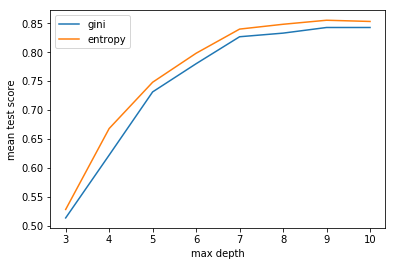

In [12]:
# You code here
criterions = params['criterion']
criterion_mask = tree_grid.cv_results_['param_criterion'].data
mean_test_score = tree_grid.cv_results_['mean_test_score']
for criterion in criterions:
    plt.plot(params['max_depth'], mean_test_score[criterion_mask==criterion], label=criterion)
plt.xlabel('max depth')
plt.ylabel('mean test score')
plt.legend(loc='upper left')
plt.show()

**1. Choose all correct statements:**
1. Optimal value of the `max_depth` parameter is on the interval [4, 9] for both criteria.<br>
**True - max_depth=9 is optimal (actually has the same mean score as max_depth=10) for criterion='gini' and max_depth=9 is optimal for 'entropy'**
2. Created plots have no intersection on the interval [3, 10]<br>
**True**
3. Created plots intersect each other only once on the interval [3, 10].<br>
**False - we clearly see no intersections**
4. The best quality for `max_depth` on the interval [3, 10] is reached using `gini` criterion .<br>
**False - best parameters are max_depth=9 and criterion='entropy'**
5. Accuracy is strictly increasing at least for one of the criteria, when `max_depth` is also increasing on the interval [3, 10]<br>
**True for entropy, because gini has the same accuracy for max_depth=9 and max_depth=10**

**2. What are the optimal values for max_depth and criterion parameters?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

In [13]:
tree_grid.best_score_, tree_grid.best_params_

(0.85525400139178842, {'criterion': 'entropy', 'max_depth': 9})

**Answer:**
* So the optimal parameters are criterion='entropy', max_depth=9

Train decision tree on `(X_train, y_train)` using the optimal values of `max_depth` and `criterion`. Compute class probabilities for `X_test`.

In [14]:
# You code here
optimal_tree = DecisionTree(**tree_grid.best_params_)
optimal_tree.fit(X_train, y_train)
probas = optimal_tree.predict_proba(X_test)

Using the given matrix, compute the mean class probabilities for all instances in `X_test`.

In [15]:
# You code here
classes_probas = probas.mean(axis=0)
classes_probas

array([ 0.09166667,  0.08611111,  0.09722222,  0.09611111,  0.11666667,
        0.12083333,  0.08333333,  0.09305556,  0.10555556,  0.10944444])

**3. What is the maximum probability in a resulted vector?**
1. 0.127
2. 0.118
3. 1.0
4. 0.09

In [16]:
max(classes_probas)

0.12083333333333333

## Regression

Download the dataset `boston` using the method `load_boston`. Split the data into train and test with the `train_test_split` method, use parameter values `test_size=0.2`, `random_state=17`. Try to train shallow regression decision trees and make sure that `variance` and `mad_median` criteria return different results.

In [17]:
# You code here
boston = load_boston()
data = boston.data
target = boston.target
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,
                                                    random_state=RANDOM_STATE)

Using 5-folds cross-validation (`GridSearchCV`) pick up the optimal values of the `max_depth` and `criterion` parameters. For the parameter `max_depth` use `range(2, 9)`, for `criterion` use {'variance', 'mad_median'}. Quality measure is `scoring`='neg_mean_squared_error'.

In [18]:
# You code here
params = {
    'criterion': ['variance', 'mad_median'],
    'max_depth': range(2, 10)
}
tree_grid = GridSearchCV(DecisionTree(), params, n_jobs=-1, cv=5,
                         verbose=True, return_train_score=False,
                         scoring='neg_mean_squared_error')
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   38.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTree(N_targets=None, criterion='gini', debug=None, max_depth=inf,
       min_samples_split=2),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['variance', 'mad_median'], 'max_depth': range(2, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=True)

Draw the plot of the mean quality measure `neg_mean_squared_error` for criteria `variance` and `mad_median` depending on `max_depth`.

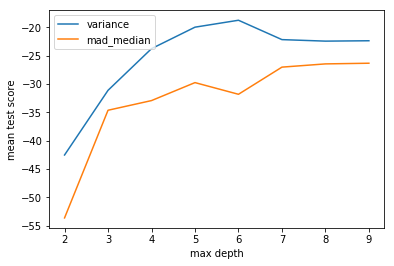

In [19]:
# You code here
criterions = params['criterion']
criterion_mask = tree_grid.cv_results_['param_criterion'].data
mean_test_score = tree_grid.cv_results_['mean_test_score']
for criterion in criterions:
    plt.plot(params['max_depth'], mean_test_score[criterion_mask==criterion], label=criterion)
plt.xlabel('max depth')
plt.ylabel('mean test score')
plt.legend(loc='upper left')
plt.show()

**4. Choose all correct statements:**
1. Created plots have no intersection on the interval [2, 8]. <br>
**True**
2. Created plots intersect each other only once on the interval [2, 8]. <br>
**False**
3. Optimal value of the `max_depth` for each of the criteria is on the border of the interval [2, 8].<br>
**False - it's inside the interval, not on borders (not 2 or 8)**
4. The best quality at `max_depth` on the interval [2, 8] is reached using `mad_median` criterion.<br>
**False - we can clearly see it on the plot**

**5. What are the optimal values for `max_depth` and `criterion` parameters?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance'.

In [20]:
tree_grid.best_params_, tree_grid.best_score_

({'criterion': 'variance', 'max_depth': 6}, -18.738980346460238)

**Answer:**
* So the optimal parameters are criterion='variance', max_depth=6